In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import string
import cv2
import os
import tensorflow as tf
import json
import pickle
import numpy as np
import nltk
nltk.download("stopwords")

from PIL import Image
from pickle import dump, load
from pycocotools.coco import COCO # COCO python library
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.models import Model, load_model

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
coco=COCO("instances_train2014.json")

loading annotations into memory...
Done (t=38.75s)
creating index...
index created!


In [3]:
annFile = "captions_train2014.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=2.22s)
creating index...
index created!


In [4]:
with open('imgIdss.pkl', 'rb') as f:
    imgIdss = pickle.load(f)

In [5]:
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [6]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Dataset: ",len(dataset))

Length of Dataset:  23453


In [7]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

51

In [10]:
img_paths = "bear.jpg" #image path

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

model = load_model('model_5.h5')
xception_model = Xception(include_top=False, pooling="avg")

1/1 [==============================] - 13s 13s/step



start a bear is standing in the grass near a fence end


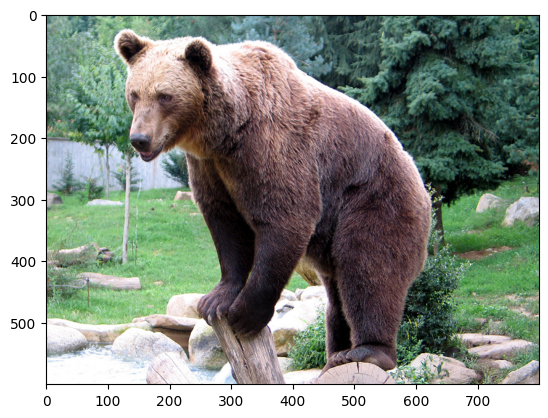

In [11]:
photo = extract_features(img_paths, xception_model)
img = Image.open(img_paths)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)